In [2]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *


In [3]:
ytopics = []
y = 1990

run_id = 66

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for ar in ars:   
    ytopics = DocTopic.objects.filter(doc__PY__in=ar["years"],run_id=run_id).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['AP'] = ar["name"]
    ndf['APn'] = ar["n"]
    if ar["name"]=="AR0":
        df = ndf
    else:
        df = df.append(ndf)
    

In [4]:
df['x'] = df.apply(lambda x: x['APn']+(np.random.rand()-0.5)*0.5,axis=1)
df['change'] = df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)
df['pchange'] = (df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)) / df.groupby(['topic__title']).ttotal.shift(1) * 100
df.pchange=df['pchange']
#print(df[['APn','pchange']])
df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.mean())

grouped = df.groupby('APn')

print(grouped.pchange.mean().reset_index())

#for name, group in grouped:
    #print(grouped.pchange.mean())

print(df[df.topic_id==115].head(125))

   APn     pchange
0    0         NaN
1    1   65.783348
2    2  193.324819
3    3  183.788765
4    4  205.700624
5    5  146.054442
6    6  -22.614492
Empty DataFrame
Columns: [topic__title, topic_id, ttotal, AP, APn, x, change, pchange, pchangen]
Index: []


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


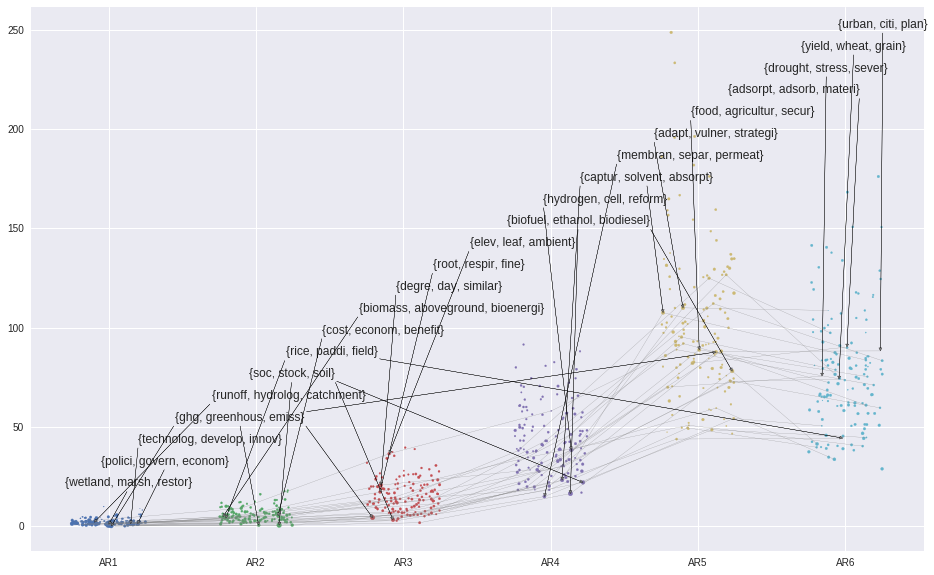

In [5]:
plt.rcParams["figure.figsize"] = [16,10]

topts = []

annotate = True

def f1(x):
    return '{0:.0f}%'.format(x)

ntopics = 5

for ar in ars:
    #break
    topar = df[df.AP==ar["name"]].sort_values(by='pchange', ascending=0).reset_index(drop=True)
    if ar["n"] > 0:
        # Write a table of top topics
        tab = topar[['topic__title','pchange']]
        tab['title'] = tab.apply(lambda x: x['topic__title'].replace('{','').replace('}',''),axis=1)
        tab = tab[['title','pchange']]  
        
        latex = tab.head(5).to_latex(float_format=f1,index=False,column_format='p{1.2cm}r')
        with open("../tables/66_top{}.tex".format(ar["name"]), "w") as f:
            f.write(latex)
 
        # Write a table of bottom topics
        latex = tab.tail(5).to_latex(float_format=f1,index=False,column_format='p{1.2cm}r')
        with open("../tables/66_bottom{}.tex".format(ar["name"]), "w") as f:
            f.write(latex)

        
        #with open("../tables/top{}_tab.tex".format(ar["name"]), "w") as f:
        #    f.write(latex)
        plt.scatter(topar.x,topar.ttotal,s=topar.pchangen*5)
        i = 0
        for index, t in topar.head(ntopics).iterrows():
            
            if t.topic_id in topts:
                i = topts.index(t.topic_id)
                a = 0
            else:
                topts.append(t.topic_id)
                i = topts.index(t.topic_id)
                a = 1
            if annotate:
                text = plt.annotate(
                    t.topic__title,
                    #t.topic__title.replace(',','\n') + " (+{}%)".format(round(t.pchange*100)),
                    xy=(t.x,t.ttotal),
                    xytext=(0.7+i*0.25,20+i*11),
                    arrowprops=dict(facecolor='grey',width=0.01,headwidth=3,headlength=3,shrink=0.0001),
                    color = None
                    #size=0.5
                )
                text.set_alpha(a)
            else:
                plt.text(
                    t.x,
                    t.ttotal,
                    str(t.topic_id) #+ " (+{}%)".format(round(t.pchange*100))                
                )
        #for index, t in topar.tail().iterrows():
        #    plt.text(t.x,t.ttotal,t.topic__title)
        
tops = df[df.topic_id.isin(topts)]
tops = tops[tops.APn>0]

for name, group in tops.groupby(['topic_id']):
    plt.plot(group.x,group.ttotal,c="grey",lw=0.2)
    
plt.xticks([1,2,3,4,5,6],["AR1","AR2","AR3","AR4","AR5","AR6"])

wide = tops.pivot(index='topic__title',columns='AP',values='pchange').reset_index()
wide.columns.name = ''
wide= wide.reset_index(drop=True)

wider = tops[['topic_id','topic__title']].drop_duplicates().merge(wide,how="left").sort_values(by='topic_id')

i = 0
if not annotate:
    for index, t in wider.iterrows():
        i+=1
        plt.text(0.7,250-i*10,"{} : {}".format(t.topic_id,t.topic__title))
        
plt.savefig('../plots/hot_topics_66.png',bbox_inches='tight')             
plt.show()



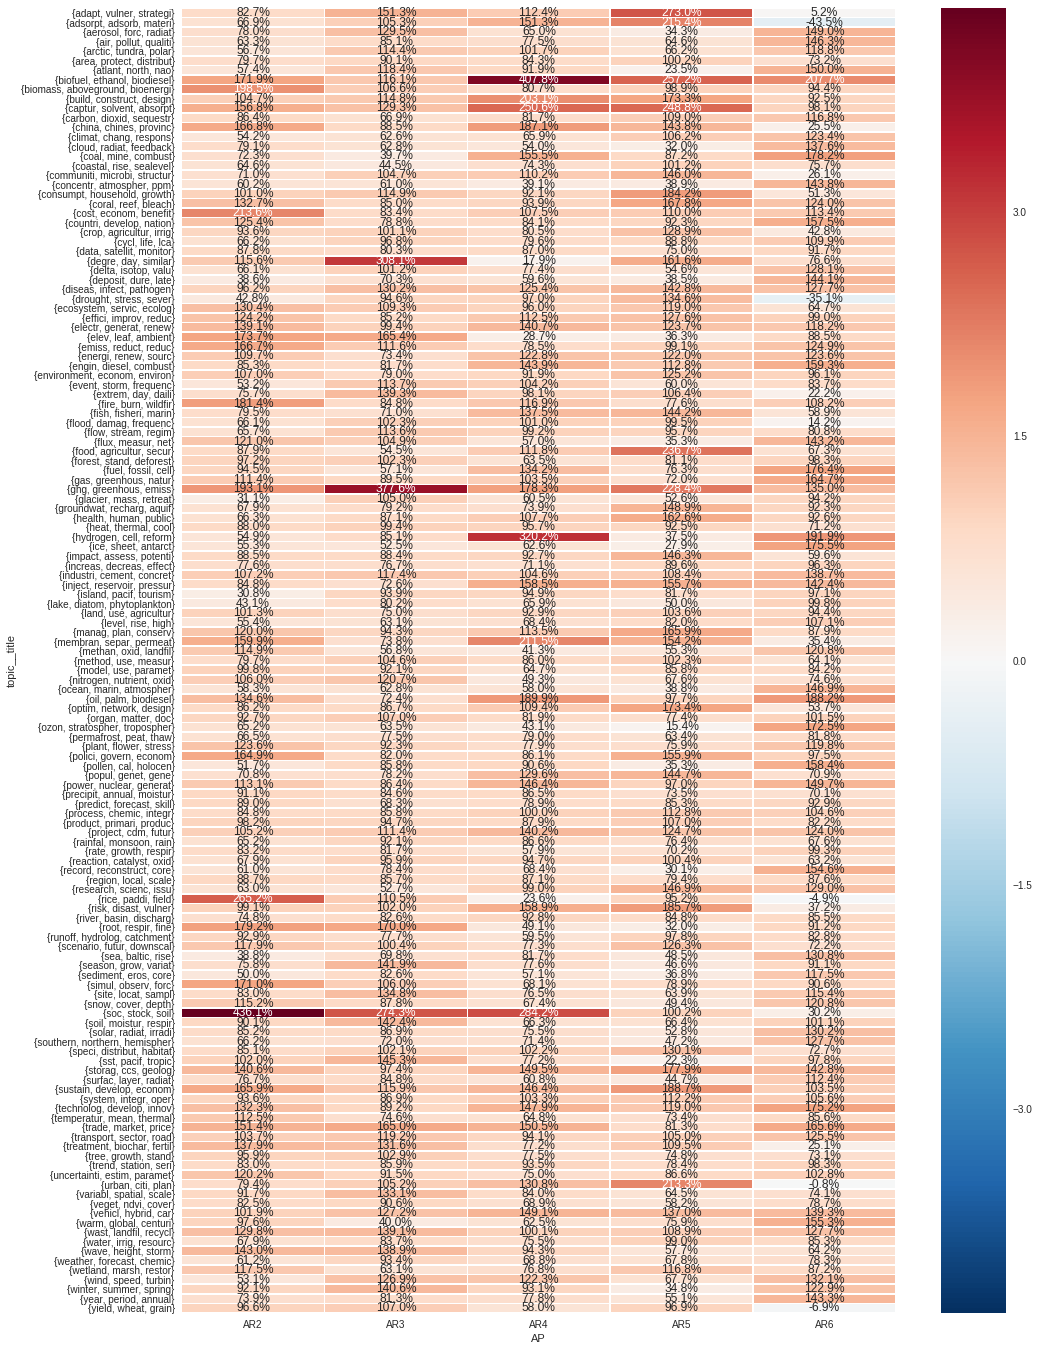

In [6]:
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = [16,24]

df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.mean())

ppdf = df[df['APn'] > 1].pivot('topic__title','AP','pchangen').fillna(0)


sns.heatmap(ppdf, annot=True, fmt=".1%", linewidths=.5)

plt.show()